Use mRNA trajectories generated from the telegraph model with different parameters, to see if the SVM algorithm can distinguish them


In [1]:
import matplotlib.pyplot as plt
import multiprocessing
import tqdm
import numpy as np
import os
import scipy.stats as st
import numba
import biocircuits
import itertools

# Define the update matrix for the reactions
# Columns: G, G*, M
# Columns: G, G*, M
update_matrix = np.array([
    [-1, 1, 0],   # G -> G* (Gene activation)
    [1, -1, 0],   # G* -> G (Gene deactivation)
    [0, 0, 1],    # G -> G + M (mRNA production)
    [0, 0, -1],   # M -> 0 (mRNA degradation)
], dtype=int)

def telegraph_model_propensity(propensities, population, t, sigma_u, sigma_b, rho, d):
    """
    Updates the propensities for the telegraph model reactions based on defined rates.

    Parameters:
        propensities: Array of propensities
        population: Array of species populations [G, G*, M]
        t: Time (not used but required by signature)
        sigma_u: Rate of G -> G* (deactivation)
        sigma_b: Rate of G* -> G (activation)
        rho: Rate of G -> G + M (mRNA production)
        d: Rate of M -> 0 (mRNA degradation)
    """
    # Unpack population
    G, G_star, M = population
    
    # Update propensities for each reaction
    propensities[0] = sigma_u * G          # G -> G*
    propensities[1] = sigma_b * G_star     # G* -> G
    propensities[2] = rho * G              # G -> G + M
    propensities[3] = d * M                # M -> 0

def sample_discrete_scipy(probs):
    """Randomly sample an index with probability given by probs."""
    return st.rv_discrete(values=(range(len(probs)), probs)).rvs()

def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

def gillespie_draw(propensity_func, propensities, population, t, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, t, *args)
        used for computing propensities. This function must return
        an array of propensities.
    population : ndarray
        Current population of particles
    t : float
        Value of the current time.
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    propensity_func(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = propensities.sum()
    
    # Compute next time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = propensities / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, t, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, propensities, population, t, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

  0%|          | 24/10000 [00:00<00:43, 230.00it/s]

100%|██████████| 10000/10000 [00:44<00:00, 225.69it/s]


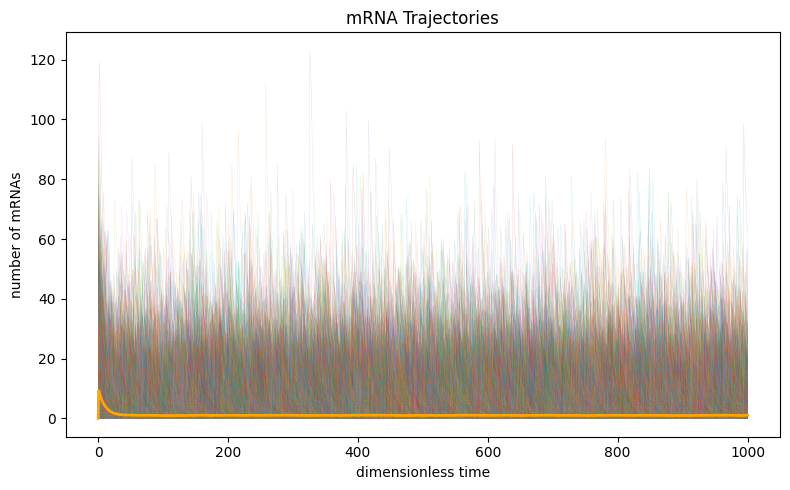

In [2]:
# Define the rates for each reaction (constants)
# To match theoretical and actual Fano factors, ensure:
# 1. Set sigma_u >>> sigma_b, bigger difference between activation and deactivation rates will ensure better results
# 2. Set rho >> sigma_u
# 3. Reaction sampled at Steady State, and t_ss >> 10 / d

sigma_u = 10.0       # Rate of G -> G* (deactivation)
sigma_b = 0.01       # Rate of G* -> G (activation)
rho = 100.0          # Rate of G -> G + M (mRNA production)
d = 0.1             # Rate of M -> 0 (mRNA degradation)

# Set simulation parameters
params = (sigma_u, sigma_b, rho, d)
time_points = np.linspace(0, 1000, 1001)  # Time range: start, stop, num 
# To ensure steady state, set time_points[-1] >> 10 / d                 
if time_points[-1] < 10 / d:
    time_points = np.linspace(0, 10 / d, int(10 / d * 10) + 1)

population_0 = np.array([1, 0, 0], dtype=int)  # Initial [G, G*, M]
size = 10000  # Number of stochastic simulations

# Seed random number generator for reproducibility
np.random.seed(42)

# Run Gillespie simulations
samples = np.empty((size, len(time_points), 3), dtype=int)
for i in tqdm.tqdm(range(size)):
    samples[i, :, :] = gillespie_ssa(telegraph_model_propensity, update_matrix, population_0, time_points, args=params)

# Plot trajectories and mean using matplotlib
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

# Plot mRNA trajectories
for x in samples[:, :, 2]:
    axs.plot(time_points, x, linewidth=0.3, alpha=0.2)
# Plot the mean of all the trajectories
axs.plot(time_points, samples[:, :, 2].mean(axis=0), linewidth=2, color='orange')
axs.set_xlabel('dimensionless time')
axs.set_ylabel('number of mRNAs')
axs.set_title('mRNA Trajectories')

plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import pandas as pd
import tqdm

# Define multiple parameter sets for different systems
parameter_sets = [
    {"sigma_u": 20.0, "sigma_b": 0.005, "rho": 80.0, "d": 0.15, "label": 0},  # Carbon Stress Condition, high gene deactivation rate, low mRNA production rate
    {"sigma_u": 5.0, "sigma_b": 0.02, "rho": 200.0, "d": 0.1, "label": 1},   # Normal Condition, low gene deactivation rate, high mRNA production rate
]

# Set up simulation parameters
time_points = np.linspace(0, 1000, 1001)  # Time range: start, stop, num 
size = 5000  # Reduce number of simulations per condition for efficiency

# Ensure steady state condition is met
for params in parameter_sets:
    if time_points[-1] < 10 / params["d"]:
        time_points = np.linspace(0, 10 / params["d"], int(10 / params["d"] * 10) + 1)

# Initialize storage for results
results = []

# Run simulations for each parameter set
for param_set in tqdm.tqdm(parameter_sets, desc="Simulating Systems"):
    sigma_u, sigma_b, rho, d, label = param_set.values()
    population_0 = np.array([1, 0, 0], dtype=int)  # Initial [G, G*, M]

    # Store mRNA trajectories
    samples = np.empty((size, len(time_points)), dtype=int)

    for i in range(size):
        samples[i, :] = gillespie_ssa(
            telegraph_model_propensity, update_matrix, population_0, time_points,
            args=(sigma_u, sigma_b, rho, d))[:, 2]  # Extract mRNA counts

    # Save each trajectory as a row with label
    for trajectory in samples:
        results.append([label] + list(trajectory))

# Convert to DataFrame and save
columns = ["label"] + [f"time_{t}" for t in time_points]
df_results = pd.DataFrame(results, columns=columns)

# Save dataset for ML classification
output_file = "traj_data/mRNA_trajectories.csv"
df_results.to_csv(output_file, index=False)

Simulating Systems: 100%|██████████| 2/2 [02:31<00:00, 75.66s/it]


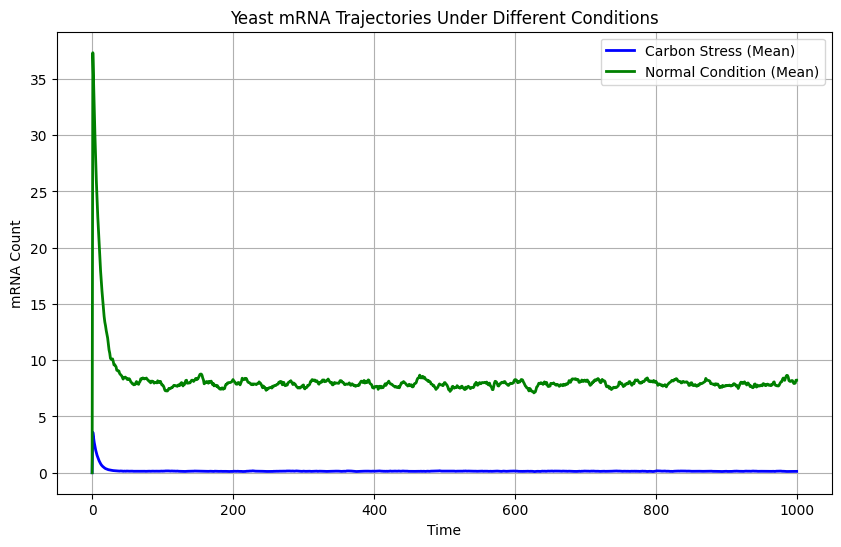

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Carbon stress
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# Time points for plotting
time_points = np.linspace(0, 1000, 1001)

# Plot mRNA trajectories
fig, ax = plt.subplots(figsize=(10, 6))

# Plot a subset of trajectories for clarity
# for traj in stress_trajectories[:50]:
#     ax.plot(time_points, traj, color='blue', alpha=0.1)
# for traj in normal_trajectories[:50]:
#     ax.plot(time_points, traj, color='green', alpha=0.1)

# Plot mean trajectory for each condition
ax.plot(time_points, stress_trajectories.mean(axis=0), color='blue', label='Carbon Stress (Mean)', linewidth=2)
ax.plot(time_points, normal_trajectories.mean(axis=0), color='green', label='Normal Condition (Mean)', linewidth=2)

# Labels and legend
ax.set_xlabel("Time")
ax.set_ylabel("mRNA Count")
ax.set_title("Yeast mRNA Trajectories Under Different Conditions")
ax.legend()
ax.grid(True)

# Show plot
plt.show()


SVM Code: